In [1]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm # Progress bar

# ================= CONFIGURATION =================
# Path to the CORRUPTED testing videos
TEST_DATA_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# Path where we will save the CLEANED videos
CLEAN_DATA_DIR = '/kaggle/working/cleaned_testing_videos'

MODEL_PATH = '/kaggle/input/flipercorrectorvlg/pytorch/default/1/rotnet_model(1).pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

def clean_dataset():
    print(f"Processing on: {DEVICE}")
    
    # 1. Load the Trained RotNet
    model = models.resnet18(pretrained=False) # No need to download weights again
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # Matches our binary training
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    
    # Standard transform for the model input
    # Note: We do NOT augment here, just resize/norm
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Find all images
    # We walk through the directory to keep structure
    image_paths = sorted(glob.glob(os.path.join(TEST_DATA_DIR, '**', '*.jpg'), recursive=True))
    print(f"Found {len(image_paths)} frames to process.")
    
    # 3. Processing Loop
    flip_count = 0
    
    for img_path in tqdm(image_paths, desc="Cleaning"):
        # A. Setup paths
        # Get relative path (e.g., "01/frame_0001.jpg") to maintain structure
        rel_path = os.path.relpath(img_path, TEST_DATA_DIR)
        save_path = os.path.join(CLEAN_DATA_DIR, rel_path)
        
        # Create folder if not exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # B. Predict Rotation
        image = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            label = predicted.item()
            
        # C. Fix and Save
        # Label 0 = Upright (Keep as is)
        # Label 1 = Flipped (Needs 180 rotation to fix)
        
        if label == 1:
            # It was detected as Upside Down, so we rotate it -180 (or 180) to fix
            fixed_image = image.transpose(Image.FLIP_TOP_BOTTOM) 
            flip_count += 1
        else:
            fixed_image = image
            
        # Save the fixed image
        fixed_image.save(save_path)

    print("-" * 30)
    print("Cleaning Complete!")
    print(f"Total Images: {len(image_paths)}")
    print(f"Images Flipped/Fixed: {flip_count}")
    print(f"Cleaned dataset saved to: {CLEAN_DATA_DIR}")

if __name__ == "__main__":
    clean_dataset()

Processing on: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Found 11706 frames to process.


Cleaning: 100%|██████████| 11706/11706 [03:00<00:00, 64.86it/s]

------------------------------
Cleaning Complete!
Total Images: 11706
Images Flipped/Fixed: 1195
Cleaned dataset saved to: /kaggle/working/cleaned_testing_videos


In [5]:
import cv2
import os
import glob
from tqdm import tqdm

# ================= CONFIGURATION =================
# Point this to the folder containing '01', '02', etc.
# Based on your screenshot, it ends in 'testing_videos'
dataset_root = r"/kaggle/working/denoised_dataset_train"


# Where to save the output MP4 files
output_folder = "rendered_videos"

# Frame rate (Frames Per Second). 
# 25 or 30 is standard. Lower it (e.g., 10) if the video feels too fast.
fps = 25 
# =================================================

def create_video_from_frames(video_folder_path, output_path, fps):
    # 1. Find all images (jpg, png, jpeg)
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        images.extend(glob.glob(os.path.join(video_folder_path, ext)))
    
    if not images:
        print(f"No images found in {video_folder_path}")
        return

    # 2. Sort them numerically! 
    # Standard sort usually fails on "frame_1" vs "frame_10", 
    # but your data has padding (0093), so standard sort usually works.
    # We use a lambda just to be safe.
    try:
        images.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
    except:
        images.sort() # Fallback if naming convention is different

    # 3. Read the first frame to get dimensions
    frame = cv2.imread(images[0])
    height, width, layers = frame.shape
    size = (width, height)

    # 4. Initialize VideoWriter
    # 'mp4v' is a standard codec for .mp4
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    # 5. Write frames
    video_name = os.path.basename(output_path)
    for image_path in tqdm(images, desc=f"Rendering {video_name}", unit="frame"):
        img = cv2.imread(image_path)
        out.write(img)

    out.release()
    print(f"Saved: {output_path}")

def main():
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get list of video directories (01, 02, etc.)
    # We assume directories inside 'testing_videos' are the video clips
    video_dirs = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]
    video_dirs.sort()

    print(f"Found {len(video_dirs)} video folders. Starting conversion...")

    for video_dir in video_dirs:
        full_path = os.path.join(dataset_root, video_dir)
        save_path = os.path.join(output_folder, f"video_{video_dir}.mp4")
        
        create_video_from_frames(full_path, save_path, fps)

    print("\nDone! Check the 'rendered_videos' folder.")

if __name__ == "__main__":
    main()

Found 16 video folders. Starting conversion...


Rendering video_01.mp4: 100%|██████████| 644/644 [00:01<00:00, 342.27frame/s]


Saved: rendered_videos/video_01.mp4


Rendering video_02.mp4: 100%|██████████| 789/789 [00:02<00:00, 339.98frame/s]


Saved: rendered_videos/video_02.mp4


Rendering video_03.mp4: 100%|██████████| 776/776 [00:02<00:00, 347.70frame/s]


Saved: rendered_videos/video_03.mp4


Rendering video_04.mp4: 100%|██████████| 492/492 [00:01<00:00, 339.59frame/s]


Saved: rendered_videos/video_04.mp4


Rendering video_05.mp4: 100%|██████████| 705/705 [00:02<00:00, 346.35frame/s]


Saved: rendered_videos/video_05.mp4


Rendering video_06.mp4: 100%|██████████| 717/717 [00:02<00:00, 346.40frame/s]


Saved: rendered_videos/video_06.mp4


Rendering video_07.mp4: 100%|██████████| 491/491 [00:01<00:00, 341.97frame/s]


Saved: rendered_videos/video_07.mp4


Rendering video_08.mp4: 100%|██████████| 840/840 [00:02<00:00, 342.89frame/s]


Saved: rendered_videos/video_08.mp4


Rendering video_09.mp4: 100%|██████████| 711/711 [00:02<00:00, 338.62frame/s]


Saved: rendered_videos/video_09.mp4


Rendering video_10.mp4: 100%|██████████| 734/734 [00:02<00:00, 347.86frame/s]


Saved: rendered_videos/video_10.mp4


Rendering video_11.mp4: 100%|██████████| 761/761 [00:02<00:00, 346.74frame/s]


Saved: rendered_videos/video_11.mp4


Rendering video_12.mp4: 100%|██████████| 145/145 [00:00<00:00, 335.00frame/s]


Saved: rendered_videos/video_12.mp4


Rendering video_13.mp4: 100%|██████████| 339/339 [00:01<00:00, 332.20frame/s]


Saved: rendered_videos/video_13.mp4


Rendering video_14.mp4: 100%|██████████| 488/488 [00:01<00:00, 341.38frame/s]


Saved: rendered_videos/video_14.mp4


Rendering video_15.mp4: 100%|██████████| 344/344 [00:01<00:00, 337.30frame/s]


Saved: rendered_videos/video_15.mp4


Rendering video_16.mp4: 100%|██████████| 228/228 [00:00<00:00, 331.74frame/s]

Saved: rendered_videos/video_16.mp4

Done! Check the 'rendered_videos' folder.


In [2]:
# 1. Clone the Repo
!git clone https://github.com/m-tassano/fastdvdnet.git
%cd fastdvdnet

# 2. Install Dependencies (Kaggle usually has these, but just in case)
!pip install -q torch torchvision opencv-python

# 3. Download Pre-trained Weights (Model.pth)
# We use the 'denoising' weights trained on high noise
!mkdir -p model
!wget -O model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth

Cloning into 'fastdvdnet'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 145 (delta 21), reused 12 (delta 9), pack-reused 109 (from 1)
Receiving objects: 100% (145/145), 34.97 MiB | 39.83 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/kaggle/working/fastdvdnet
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

In [3]:
import os
import shutil
import glob
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys

# ================= CONFIGURATION =================
# 1. WHERE ARE YOUR NOISY FRAMES?
# Adjust this to the root folder containing '01', '02', etc.
INPUT_ROOT = "/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos" 

# 2. WHERE TO SAVE CLEAN FRAMES?
OUTPUT_ROOT = "/kaggle/working/denoised_dataset_train"

# 3. SETTINGS (The Winning Formula)
NOISE_SIGMA = 40 / 255.0  
BATCH_SIZE = 16
NUM_WORKERS = 4
# =================================================

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def install_and_setup():
    if not os.path.exists("fastdvdnet"):
        print("🛠️ Cloning FastDVDnet...")
        os.system("git clone https://github.com/m-tassano/fastdvdnet.git")
        os.system("pip install tensorboardX")
    
    if not os.path.exists("fastdvdnet/model/model.pth"):
        os.makedirs("fastdvdnet/model", exist_ok=True)
        os.system("wget -O fastdvdnet/model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth")

# --- DATASET ---
class FrameSequenceDataset(Dataset):
    def __init__(self, frame_paths):
        self.frame_paths = frame_paths
        self.total = len(frame_paths)
        
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        # Sliding Window of 5 frames
        indices = [max(0, min(self.total - 1, idx + offset)) for offset in range(-2, 3)]
        
        frames = []
        for i in indices:
            path = self.frame_paths[i]
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((360, 640, 3), dtype=np.uint8) # Fallback size
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            frames.append(img)
            
        stack = np.concatenate(frames, axis=2) # (H, W, 15)
        tensor = torch.from_numpy(stack).permute(2, 0, 1) # (15, H, W)
        return tensor

# --- MAIN LOOP ---
def run_mass_cleaning():
    install_and_setup()
    
    # Import Model
    sys.path.append("fastdvdnet")
    try:
        from models import FastDVDnet
    except ImportError:
        from fastdvdnet.models import FastDVDnet

    # Find all video folders (01, 02, ... 21)
    video_folders = sorted(glob.glob(os.path.join(INPUT_ROOT, "*")))
    # Filter to ensure they are directories
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    
    print(f"🌍 Found {len(video_folders)} videos to clean.")

    # Setup Model Once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastDVDnet(num_input_frames=5)
    
    state_dict = torch.load("fastdvdnet/model/model.pth", map_location=device)
    new_state = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state)
    
    if torch.cuda.device_count() > 1:
        print(f"🔥 Dual GPU Active")
        model = nn.DataParallel(model)
        
    model.to(device)
    model.eval()

    # --- LOOP OVER VIDEOS ---
    for vid_path in video_folders:
        vid_id = os.path.basename(vid_path)
        print(f"\n🎬 Processing Video: {vid_id}")
        
        # 1. Get Frames
        files = glob.glob(os.path.join(vid_path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        if not files:
            print(f"⚠️ Skipping {vid_id} (No images found)")
            continue
            
        # 2. Setup Output Folder
        save_dir = os.path.join(OUTPUT_ROOT, vid_id)
        if os.path.exists(save_dir): shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        # 3. Process
        dataset = FrameSequenceDataset(files)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
        )
        
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(loader, desc=f"Cleaning {vid_id}")):
                data = data.to(device)
                B, C, H, W = data.shape
                
                noise_sigma = torch.full((B, 1, H, W), NOISE_SIGMA).to(device)
                
                clean_batch = model(data, noise_sigma)
                clean_batch = clean_batch.permute(0, 2, 3, 1).cpu().numpy()
                
                for i in range(B):
                    img = np.clip(clean_batch[i] * 255, 0, 255).astype(np.uint8)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    
                    # Standardized Name: frame_0000.jpg
                    global_idx = batch_idx * BATCH_SIZE + i
                    save_name = f"frame_{global_idx:04d}.jpg"
                    
                    cv2.imwrite(os.path.join(save_dir, save_name), img_bgr)
                    
    print(f"\n✅✅✅ ALL VIDEOS CLEANED! Saved to: {OUTPUT_ROOT}")

if __name__ == "__main__":
    run_mass_cleaning()

🛠️ Cloning FastDVDnet...


Cloning into 'fastdvdnet'...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00


--2026-01-01 04:59:12--  https://github.com/m-tassano/fastdvdnet/raw/master/model.pth
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth [following]
--2026-01-01 04:59:13--  https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9971551 (9.5M) [application/octet-stream]
Saving to: ‘fastdvdnet/model/model.pth’

     0K .......... .......... .......... .......... ..........  0% 4.19M 2s
    50K .......... .......... .......... .......... ..........  1% 14.9M 1s
   100K .......... .......... ........

🌍 Found 16 videos to clean.
🔥 Dual GPU Active

🎬 Processing Video: 01


Cleaning 01: 100%|██████████| 41/41 [00:39<00:00,  1.03it/s]



🎬 Processing Video: 02


Cleaning 02: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]



🎬 Processing Video: 03


Cleaning 03: 100%|██████████| 49/49 [00:43<00:00,  1.14it/s]



🎬 Processing Video: 04


Cleaning 04: 100%|██████████| 31/31 [00:28<00:00,  1.07it/s]



🎬 Processing Video: 05


Cleaning 05: 100%|██████████| 45/45 [00:40<00:00,  1.11it/s]



🎬 Processing Video: 06


Cleaning 06: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]



🎬 Processing Video: 07


Cleaning 07: 100%|██████████| 31/31 [00:30<00:00,  1.01it/s]



🎬 Processing Video: 08


Cleaning 08: 100%|██████████| 53/53 [00:50<00:00,  1.05it/s]



🎬 Processing Video: 09


Cleaning 09: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]



🎬 Processing Video: 10


Cleaning 10: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]



🎬 Processing Video: 11


Cleaning 11: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]



🎬 Processing Video: 12


Cleaning 12: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]



🎬 Processing Video: 13


Cleaning 13: 100%|██████████| 22/22 [00:21<00:00,  1.02it/s]



🎬 Processing Video: 14


Cleaning 14: 100%|██████████| 31/31 [00:30<00:00,  1.02it/s]



🎬 Processing Video: 15


Cleaning 15: 100%|██████████| 22/22 [00:22<00:00,  1.01s/it]



🎬 Processing Video: 16


Cleaning 16: 100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


✅✅✅ ALL VIDEOS CLEANED! Saved to: /kaggle/working/denoised_dataset_train


In [4]:
import os
import shutil
import glob
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys

# ================= CONFIGURATION =================
# 1. WHERE ARE YOUR NOISY FRAMES?
# Adjust this to the root folder containing '01', '02', etc.
INPUT_ROOT = "/kaggle/working/cleaned_testing_videos" 

# 2. WHERE TO SAVE CLEAN FRAMES?
OUTPUT_ROOT = "/kaggle/working/denoised_dataset"

# 3. SETTINGS (The Winning Formula)
NOISE_SIGMA = 40 / 255.0  
BATCH_SIZE = 16
NUM_WORKERS = 4
# =================================================

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def install_and_setup():
    if not os.path.exists("fastdvdnet"):
        print("🛠️ Cloning FastDVDnet...")
        os.system("git clone https://github.com/m-tassano/fastdvdnet.git")
        os.system("pip install tensorboardX")
    
    if not os.path.exists("fastdvdnet/model/model.pth"):
        os.makedirs("fastdvdnet/model", exist_ok=True)
        os.system("wget -O fastdvdnet/model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth")

# --- DATASET ---
class FrameSequenceDataset(Dataset):
    def __init__(self, frame_paths):
        self.frame_paths = frame_paths
        self.total = len(frame_paths)
        
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        # Sliding Window of 5 frames
        indices = [max(0, min(self.total - 1, idx + offset)) for offset in range(-2, 3)]
        
        frames = []
        for i in indices:
            path = self.frame_paths[i]
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((360, 640, 3), dtype=np.uint8) # Fallback size
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            frames.append(img)
            
        stack = np.concatenate(frames, axis=2) # (H, W, 15)
        tensor = torch.from_numpy(stack).permute(2, 0, 1) # (15, H, W)
        return tensor

# --- MAIN LOOP ---
def run_mass_cleaning():
    install_and_setup()
    
    # Import Model
    sys.path.append("fastdvdnet")
    try:
        from models import FastDVDnet
    except ImportError:
        from fastdvdnet.models import FastDVDnet

    # Find all video folders (01, 02, ... 21)
    video_folders = sorted(glob.glob(os.path.join(INPUT_ROOT, "*")))
    # Filter to ensure they are directories
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    
    print(f"🌍 Found {len(video_folders)} videos to clean.")

    # Setup Model Once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastDVDnet(num_input_frames=5)
    
    state_dict = torch.load("fastdvdnet/model/model.pth", map_location=device)
    new_state = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state)
    
    if torch.cuda.device_count() > 1:
        print(f"🔥 Dual GPU Active")
        model = nn.DataParallel(model)
        
    model.to(device)
    model.eval()

    # --- LOOP OVER VIDEOS ---
    for vid_path in video_folders:
        vid_id = os.path.basename(vid_path)
        print(f"\n🎬 Processing Video: {vid_id}")
        
        # 1. Get Frames
        files = glob.glob(os.path.join(vid_path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        if not files:
            print(f"⚠️ Skipping {vid_id} (No images found)")
            continue
            
        # 2. Setup Output Folder
        save_dir = os.path.join(OUTPUT_ROOT, vid_id)
        if os.path.exists(save_dir): shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        # 3. Process
        dataset = FrameSequenceDataset(files)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
        )
        
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(loader, desc=f"Cleaning {vid_id}")):
                data = data.to(device)
                B, C, H, W = data.shape
                
                noise_sigma = torch.full((B, 1, H, W), NOISE_SIGMA).to(device)
                
                clean_batch = model(data, noise_sigma)
                clean_batch = clean_batch.permute(0, 2, 3, 1).cpu().numpy()
                
                for i in range(B):
                    img = np.clip(clean_batch[i] * 255, 0, 255).astype(np.uint8)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    
                    # Standardized Name: frame_0000.jpg
                    global_idx = batch_idx * BATCH_SIZE + i
                    save_name = f"frame_{global_idx:04d}.jpg"
                    
                    cv2.imwrite(os.path.join(save_dir, save_name), img_bgr)
                    
    print(f"\n✅✅✅ ALL VIDEOS CLEANED! Saved to: {OUTPUT_ROOT}")

if __name__ == "__main__":
    run_mass_cleaning()

🌍 Found 21 videos to clean.
🔥 Dual GPU Active

🎬 Processing Video: 01


Cleaning 01: 100%|██████████| 32/32 [00:31<00:00,  1.03it/s]



🎬 Processing Video: 02


Cleaning 02: 100%|██████████| 76/76 [01:11<00:00,  1.06it/s]



🎬 Processing Video: 03


Cleaning 03: 100%|██████████| 47/47 [00:45<00:00,  1.04it/s]



🎬 Processing Video: 04


Cleaning 04: 100%|██████████| 60/60 [00:56<00:00,  1.07it/s]



🎬 Processing Video: 05


Cleaning 05: 100%|██████████| 63/63 [00:59<00:00,  1.07it/s]



🎬 Processing Video: 06


Cleaning 06: 100%|██████████| 40/40 [00:38<00:00,  1.04it/s]



🎬 Processing Video: 07


Cleaning 07: 100%|██████████| 37/37 [00:35<00:00,  1.03it/s]



🎬 Processing Video: 08


Cleaning 08: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]



🎬 Processing Video: 09


Cleaning 09: 100%|██████████| 23/23 [00:22<00:00,  1.02it/s]



🎬 Processing Video: 10


Cleaning 10: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]



🎬 Processing Video: 11


Cleaning 11: 100%|██████████| 30/30 [00:28<00:00,  1.04it/s]



🎬 Processing Video: 12


Cleaning 12: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]



🎬 Processing Video: 13


Cleaning 13: 100%|██████████| 33/33 [00:32<00:00,  1.02it/s]



🎬 Processing Video: 14


Cleaning 14: 100%|██████████| 31/31 [00:30<00:00,  1.01it/s]



🎬 Processing Video: 15


Cleaning 15: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]



🎬 Processing Video: 16


Cleaning 16: 100%|██████████| 47/47 [00:44<00:00,  1.05it/s]



🎬 Processing Video: 17


Cleaning 17: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]



🎬 Processing Video: 18


Cleaning 18: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s]



🎬 Processing Video: 19


Cleaning 19: 100%|██████████| 15/15 [00:15<00:00,  1.02s/it]



🎬 Processing Video: 20


Cleaning 20: 100%|██████████| 18/18 [00:18<00:00,  1.00s/it]



🎬 Processing Video: 21


Cleaning 21: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


✅✅✅ ALL VIDEOS CLEANED! Saved to: /kaggle/working/denoised_dataset


In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import glob
from tqdm import tqdm
import gc
import numpy as np

# ================= CONFIGURATION =================
TRAIN_DIR = '/kaggle/working/denoised_dataset_train'
SAVE_PATH = 'roadmap_lite_model.pth'

BATCH_SIZE = 16          
IMG_SIZE = 256           
EPOCHS = 30
LR = 0.0003
T_STEPS = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. COMPONENTS ---
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, 1, stride, 0)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + self.shortcut(x) 
        return F.relu(out)

class ConvGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 2 * hidden_dim, kernel_size, 1, self.padding, bias=bias)
    def forward(self, input_tensor, cur_state):
        if cur_state is None:
            cur_state = torch.zeros(input_tensor.size(0), self.hidden_dim, input_tensor.size(2), input_tensor.size(3)).to(input_tensor.device)
        combined = torch.cat([input_tensor, cur_state], dim=1)
        combined_conv = self.conv(combined)
        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)
        new_state = (1 - update_gate) * cur_state + update_gate * torch.tanh(input_tensor)
        return new_state

# --- 2. ROADMAP LITE ---
class ROADMAP_LITE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 64, 3, 1, 1); self.enc2 = ResBlock(64, 128, 2)
        self.enc3 = ResBlock(128, 256, 2); self.enc4 = ResBlock(256, 512, 2)
        self.gru1 = ConvGRUCell(512, 512, 3, True)
        self.gru2 = ConvGRUCell(256, 256, 3, True)
        self.gru3 = ConvGRUCell(128, 128, 3, True)
        self.dec1 = ResBlock(512 + 256, 256, 1); self.dec2 = ResBlock(256 + 128, 128, 1)
        self.dec3 = ResBlock(128 + 64, 64, 1); self.final = nn.Conv2d(64, 3, 3, 1, 1)
    def forward(self, frames):
        batch, t_steps, c, h, w = frames.size()
        h1, h2, h3 = None, None, None
        for t in range(t_steps):
            xt = frames[:, t]
            f1 = F.relu(self.enc1(xt)); f2 = self.enc2(f1)
            f3 = self.enc3(f2); f4 = self.enc4(f3)
            h1 = self.gru1(f4, h1); h2 = self.gru2(f3, h2); h3 = self.gru3(f2, h3)
        up1 = F.interpolate(h1, scale_factor=2); cat1 = torch.cat([up1, h2], dim=1); d1 = self.dec1(cat1)
        up2 = F.interpolate(d1, scale_factor=2); cat2 = torch.cat([up2, h3], dim=1); d2 = self.dec2(cat2)
        up3 = F.interpolate(d2, scale_factor=2); cat3 = torch.cat([up3, f1], dim=1); d3 = self.dec3(cat3)
        return torch.tanh(self.final(d3))

# --- 3. LOSSES ---
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features
        for m in vgg.modules():
            if isinstance(m, nn.ReLU): m.inplace = False
        self.blocks = nn.ModuleList([vgg[:4], vgg[4:9], vgg[9:16], vgg[16:23]])
        for param in self.parameters(): param.requires_grad = False
    def forward(self, x, y):
        loss = 0
        for block in self.blocks:
            x, y = block(x), block(y)
            loss += torch.mean(torch.abs(x - y))
        return loss

# --- 4. TRAINING ---
class RoadmapDataset(Dataset):
    def __init__(self, root, transform=None):
        self.clips = []
        self.transform = transform
        for vid in sorted(os.listdir(root)):
            path = os.path.join(root, vid)
            frames = sorted(glob.glob(os.path.join(path, '*.jpg')))
            if len(frames) < T_STEPS + 1: continue
            for i in range(len(frames) - T_STEPS):
                self.clips.append((frames[i:i+T_STEPS], frames[i+T_STEPS]))
    def __len__(self): return len(self.clips)
    def __getitem__(self, idx):
        in_paths, tgt_path = self.clips[idx]
        in_imgs = [self.transform(Image.open(p).convert('RGB')) for p in in_paths]
        tgt_img = self.transform(Image.open(tgt_path).convert('RGB'))
        return torch.stack(in_imgs), tgt_img

def train():
    torch.cuda.empty_cache(); gc.collect()
    print(f"Training ROADMAP LITE on {torch.cuda.device_count()} GPUs")
    
    tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    loader = DataLoader(RoadmapDataset(TRAIN_DIR, tf), batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    model = ROADMAP_LITE()
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    model = model.to(DEVICE)
    
    vgg_loss = VGGLoss().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    l1_loss = nn.L1Loss(); l2_loss = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler()

    try:
        for epoch in range(EPOCHS):
            model.train()
            loop = tqdm(loader, desc=f"Ep {epoch+1}")
            
            # Epoch Accumulators
            epoch_loss = 0.0
            epoch_int = 0.0
            epoch_grad = 0.0
            epoch_noise = 0.0
            count = 0
            
            for inputs, target in loop:
                inputs, target = inputs.to(DEVICE), target.to(DEVICE)
                optimizer.zero_grad(set_to_none=True)
                
                with torch.cuda.amp.autocast():
                    pred = model(inputs)
                    
                    # Calculate Individual Losses
                    loss_int = l2_loss(pred, target)
                    loss_grad = l1_loss(pred, target)
                    loss_noise = vgg_loss(pred, target)
                    
                    total_loss = loss_int + loss_grad + loss_noise

                scaler.scale(total_loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # Update Accumulators
                b_size = inputs.size(0)
                epoch_loss += total_loss.item() * b_size
                epoch_int += loss_int.item() * b_size
                epoch_grad += loss_grad.item() * b_size
                epoch_noise += loss_noise.item() * b_size
                count += b_size
                
                # Update Progress Bar with Breakdown
                loop.set_postfix(
                    T=total_loss.item(), 
                    Int=loss_int.item(), 
                    Grad=loss_grad.item(), 
                    Noise=loss_noise.item()
                )
            
            # Print Epoch Averages
            avg_loss = epoch_loss / count
            avg_int = epoch_int / count
            avg_grad = epoch_grad / count
            avg_noise = epoch_noise / count
            print(f"--> Ep {epoch+1} Avg: Total={avg_loss:.4f} | Int={avg_int:.4f} | Grad={avg_grad:.4f} | Noise={avg_noise:.4f}")
            
            torch.cuda.empty_cache()

    except KeyboardInterrupt:
        print("\n\n[!] Keyboard Interrupt detected. Stopping training...")

    # Save logic works for both successful finish AND Interrupt
    state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
    torch.save(state, SAVE_PATH)
    print(f"Model saved safely to {SAVE_PATH}")

if __name__ == "__main__":
    train()

Training ROADMAP LITE on 2 GPUs


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 223MB/s] 
/tmp/ipykernel_47/3217404006.py:130: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Ep 1:   0%|          | 0/572 [00:00<?, ?it/s]/tmp/ipykernel_47/3217404006.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda

--> Ep 1 Avg: Total=0.3321 | Int=0.0041 | Grad=0.0238 | Noise=0.3042


Ep 2: 100%|██████████| 572/572 [10:24<00:00,  1.09s/it, Grad=0.00994, Int=0.000369, Noise=0.197, T=0.207]


--> Ep 2 Avg: Total=0.2083 | Int=0.0007 | Grad=0.0107 | Noise=0.1969


Ep 3: 100%|██████████| 572/572 [10:24<00:00,  1.09s/it, Grad=0.00879, Int=0.000209, Noise=0.139, T=0.148]


--> Ep 3 Avg: Total=0.1946 | Int=0.0005 | Grad=0.0096 | Noise=0.1845


Ep 4: 100%|██████████| 572/572 [10:24<00:00,  1.09s/it, Grad=0.00938, Int=0.000339, Noise=0.201, T=0.211]


--> Ep 4 Avg: Total=0.1856 | Int=0.0004 | Grad=0.0090 | Noise=0.1762


Ep 5: 100%|██████████| 572/572 [10:24<00:00,  1.09s/it, Grad=0.00867, Int=0.000371, Noise=0.186, T=0.195]


--> Ep 5 Avg: Total=0.1805 | Int=0.0003 | Grad=0.0087 | Noise=0.1714


Ep 6: 100%|██████████| 572/572 [10:23<00:00,  1.09s/it, Grad=0.00771, Int=0.000294, Noise=0.161, T=0.169]


--> Ep 6 Avg: Total=0.1767 | Int=0.0003 | Grad=0.0085 | Noise=0.1679


Ep 7: 100%|██████████| 572/572 [10:22<00:00,  1.09s/it, Grad=0.00773, Int=0.000167, Noise=0.152, T=0.16] 


--> Ep 7 Avg: Total=0.1737 | Int=0.0003 | Grad=0.0083 | Noise=0.1652


Ep 8: 100%|██████████| 572/572 [10:22<00:00,  1.09s/it, Grad=0.0086, Int=0.00023, Noise=0.181, T=0.189]  


--> Ep 8 Avg: Total=0.1714 | Int=0.0003 | Grad=0.0082 | Noise=0.1629


Ep 9: 100%|██████████| 572/572 [10:23<00:00,  1.09s/it, Grad=0.00799, Int=0.000237, Noise=0.169, T=0.177]


--> Ep 9 Avg: Total=0.1692 | Int=0.0002 | Grad=0.0080 | Noise=0.1609


Ep 10: 100%|██████████| 572/572 [10:23<00:00,  1.09s/it, Grad=0.00757, Int=0.000188, Noise=0.151, T=0.159]


--> Ep 10 Avg: Total=0.1677 | Int=0.0002 | Grad=0.0080 | Noise=0.1595


Ep 11: 100%|██████████| 572/572 [10:22<00:00,  1.09s/it, Grad=0.00846, Int=0.000216, Noise=0.185, T=0.194]


--> Ep 11 Avg: Total=0.1659 | Int=0.0002 | Grad=0.0079 | Noise=0.1578


Ep 12: 100%|██████████| 572/572 [10:21<00:00,  1.09s/it, Grad=0.00746, Int=0.00022, Noise=0.154, T=0.162] 


--> Ep 12 Avg: Total=0.1644 | Int=0.0002 | Grad=0.0078 | Noise=0.1563


Ep 13: 100%|██████████| 572/572 [10:21<00:00,  1.09s/it, Grad=0.00603, Int=9.52e-5, Noise=0.119, T=0.125] 


--> Ep 13 Avg: Total=0.1630 | Int=0.0002 | Grad=0.0077 | Noise=0.1551


Ep 14: 100%|██████████| 572/572 [10:21<00:00,  1.09s/it, Grad=0.00835, Int=0.000215, Noise=0.177, T=0.185]


--> Ep 14 Avg: Total=0.1617 | Int=0.0002 | Grad=0.0076 | Noise=0.1538


Ep 15: 100%|██████████| 572/572 [10:21<00:00,  1.09s/it, Grad=0.00752, Int=0.000214, Noise=0.154, T=0.162]


--> Ep 15 Avg: Total=0.1606 | Int=0.0002 | Grad=0.0076 | Noise=0.1528


Ep 16: 100%|██████████| 572/572 [10:22<00:00,  1.09s/it, Grad=0.00835, Int=0.00023, Noise=0.176, T=0.185] 


--> Ep 16 Avg: Total=0.1592 | Int=0.0002 | Grad=0.0075 | Noise=0.1515


Ep 17: 100%|██████████| 572/572 [10:23<00:00,  1.09s/it, Grad=0.00747, Int=0.000122, Noise=0.157, T=0.165]


--> Ep 17 Avg: Total=0.1583 | Int=0.0002 | Grad=0.0075 | Noise=0.1506


Ep 18: 100%|██████████| 572/572 [10:22<00:00,  1.09s/it, Grad=0.00757, Int=0.00018, Noise=0.151, T=0.159] 


--> Ep 18 Avg: Total=0.1572 | Int=0.0002 | Grad=0.0074 | Noise=0.1495


Ep 19: 100%|██████████| 572/572 [10:21<00:00,  1.09s/it, Grad=0.0083, Int=0.000252, Noise=0.155, T=0.163] 


--> Ep 19 Avg: Total=0.1562 | Int=0.0002 | Grad=0.0074 | Noise=0.1486


Ep 20: 100%|██████████| 572/572 [10:21<00:00,  1.09s/it, Grad=0.00736, Int=0.000152, Noise=0.149, T=0.156]


--> Ep 20 Avg: Total=0.1555 | Int=0.0002 | Grad=0.0074 | Noise=0.1480


Ep 21: 100%|██████████| 572/572 [10:22<00:00,  1.09s/it, Grad=0.0068, Int=9.22e-5, Noise=0.15, T=0.157]   


--> Ep 21 Avg: Total=0.1545 | Int=0.0002 | Grad=0.0073 | Noise=0.1470


Ep 22:  95%|█████████▌| 545/572 [09:54<00:29,  1.09s/it, Grad=0.00658, Int=0.000116, Noise=0.131, T=0.138]



[!] Keyboard Interrupt detected. Stopping training...
Model saved safely to roadmap_lite_model.pth


Visualizing Video: 10
Found 722 frames.
Running Inference...
Plot saved to anomaly_plot_video_10.png


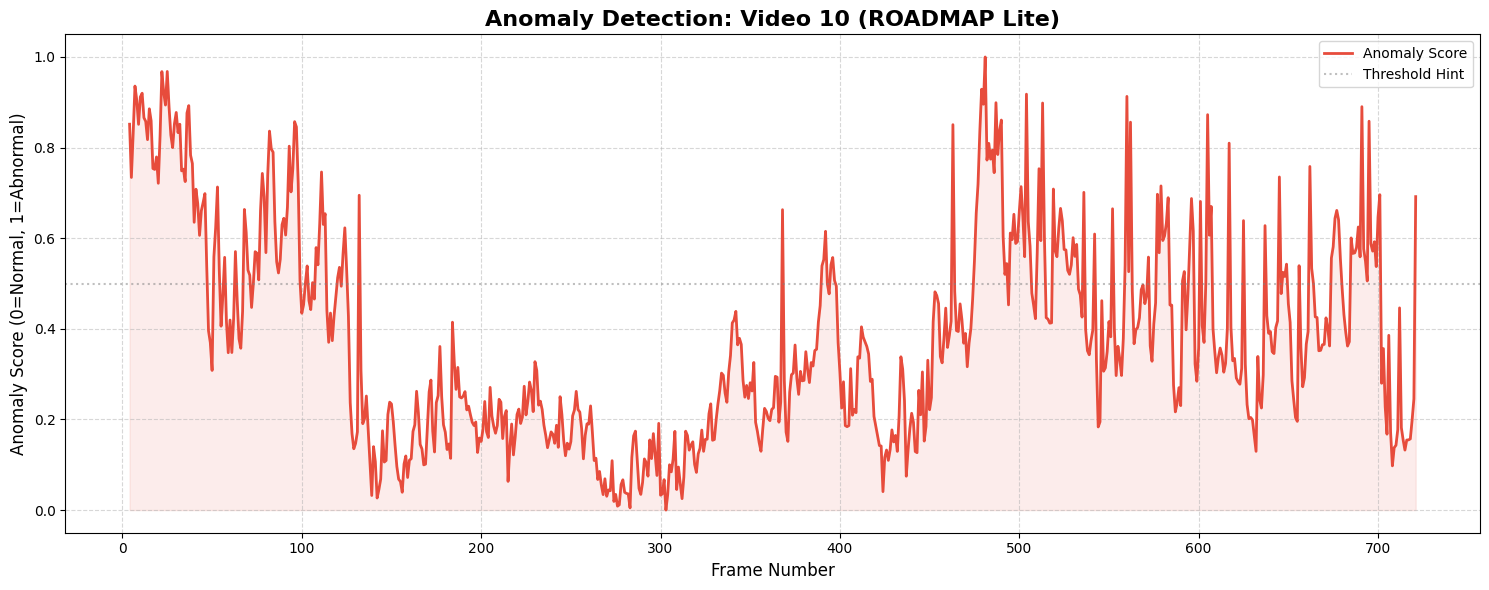

In [10]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# ================= CONFIGURATION =================
# 1. Path to CLEANED TEST VIDEOS
CLEAN_TEST_DIR = '/kaggle/working/denoised_dataset' 

# 2. Path to your saved LITE model
MODEL_PATH = '/kaggle/working/fastdvdnet/roadmap_lite_model.pth'

IMG_SIZE = 256
T_STEPS = 4  # Must match what you trained with
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. RE-DEFINE ARCHITECTURE (Must match training exactly) ---
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, 1, stride, 0)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + self.shortcut(x) 
        return F.relu(out)

class ConvGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 2 * hidden_dim, kernel_size, 1, self.padding, bias=bias)
    def forward(self, input_tensor, cur_state):
        if cur_state is None:
            cur_state = torch.zeros(input_tensor.size(0), self.hidden_dim, input_tensor.size(2), input_tensor.size(3)).to(input_tensor.device)
        combined = torch.cat([input_tensor, cur_state], dim=1)
        combined_conv = self.conv(combined)
        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)
        new_state = (1 - update_gate) * cur_state + update_gate * torch.tanh(input_tensor)
        return new_state

class ROADMAP_LITE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 64, 3, 1, 1); self.enc2 = ResBlock(64, 128, 2)
        self.enc3 = ResBlock(128, 256, 2); self.enc4 = ResBlock(256, 512, 2)
        
        # Lite Paths (Direct GRU)
        self.gru1 = ConvGRUCell(512, 512, 3, True)
        self.gru2 = ConvGRUCell(256, 256, 3, True)
        self.gru3 = ConvGRUCell(128, 128, 3, True)
        
        self.dec1 = ResBlock(512 + 256, 256, 1); self.dec2 = ResBlock(256 + 128, 128, 1)
        self.dec3 = ResBlock(128 + 64, 64, 1); self.final = nn.Conv2d(64, 3, 3, 1, 1)

    def forward(self, frames):
        batch, t_steps, c, h, w = frames.size()
        h1, h2, h3 = None, None, None
        for t in range(t_steps):
            xt = frames[:, t]
            f1 = F.relu(self.enc1(xt)); f2 = self.enc2(f1)
            f3 = self.enc3(f2); f4 = self.enc4(f3)
            h1 = self.gru1(f4, h1); h2 = self.gru2(f3, h2); h3 = self.gru3(f2, h3)
            
        up1 = F.interpolate(h1, scale_factor=2); cat1 = torch.cat([up1, h2], dim=1); d1 = self.dec1(cat1)
        up2 = F.interpolate(d1, scale_factor=2); cat2 = torch.cat([up2, h3], dim=1); d2 = self.dec2(cat2)
        up3 = F.interpolate(d2, scale_factor=2); cat3 = torch.cat([up3, f1], dim=1); d3 = self.dec3(cat3)
        return torch.tanh(self.final(d3))

# --- 2. PSNR CALCULATION FUNCTION ---
def calc_psnr(pred, target):
    # Denormalize first: tanh output is [-1, 1] -> [0, 1]
    pred = (pred + 1) / 2
    target = (target + 1) / 2
    
    mse = torch.mean((pred - target) ** 2, dim=[1, 2, 3]) # Mean per image
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

# --- 3. MAIN VISUALIZATION FUNCTION ---
def visualize_video(vid_id):
    print(f"Visualizing Video: {vid_id}")
    
    # Locate Video
    vid_path = os.path.join(CLEAN_TEST_DIR, str(vid_id).zfill(2)) # Handle "1" vs "01"
    if not os.path.exists(vid_path):
        # Try finding folder regardless of leading zero
        candidates = [d for d in os.listdir(CLEAN_TEST_DIR) if str(int(d)) == str(int(vid_id))]
        if not candidates:
            print(f"Error: Video {vid_id} not found in {CLEAN_TEST_DIR}")
            return
        vid_path = os.path.join(CLEAN_TEST_DIR, candidates[0])
        
    frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
    print(f"Found {len(frames)} frames.")
    
    # Load Model
    model = ROADMAP_LITE()
    if os.path.exists(MODEL_PATH):
        state = torch.load(MODEL_PATH, map_location=DEVICE)
        # Handle DataParallel cleaning
        new_state = {k.replace('module.', ''): v for k, v in state.items()}
        model.load_state_dict(new_state)
    else:
        print("Model file not found!")
        return
    
    model.to(DEVICE)
    model.eval()
    
    # Transform
    tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    
    psnr_list = []
    frame_indices = []
    
    print("Running Inference...")
    with torch.no_grad():
        for i in range(len(frames) - T_STEPS):
            # Input: T frames
            clip = frames[i : i + T_STEPS]
            # Target: The NEXT frame (T+1)
            target_path = frames[i + T_STEPS]
            
            input_imgs = [tf(Image.open(p).convert('RGB')) for p in clip]
            target_img = tf(Image.open(target_path).convert('RGB')).unsqueeze(0).to(DEVICE)
            
            input_tensor = torch.stack(input_imgs).unsqueeze(0).to(DEVICE) # (1, T, 3, H, W)
            
            # Predict
            pred_img = model(input_tensor)
            
            # Calculate Quality (PSNR)
            psnr = calc_psnr(pred_img, target_img)
            psnr_list.append(psnr)
            frame_indices.append(i + T_STEPS) # Mapping to the predicted frame index
            
    # --- 4. NORMALIZE TO ANOMALY SCORE ---
    # Paper Formula: S_t = 1 - (R_t - min(R)) / (max(R) - min(R)) 
    psnr_array = np.array(psnr_list)
    min_r = np.min(psnr_array)
    max_r = np.max(psnr_array)
    
    # Inverse: Low PSNR (Bad prediction) -> High Anomaly Score
    anomaly_scores = 1.0 - ((psnr_array - min_r) / (max_r - min_r))
    
    # --- 5. PLOT ---
    plt.figure(figsize=(15, 6))
    
    # Plot the signal
    plt.plot(frame_indices, anomaly_scores, color='#e74c3c', linewidth=2, label='Anomaly Score')
    
    # Add styling
    plt.title(f'Anomaly Detection: Video {vid_id} (ROADMAP Lite)', fontsize=16, fontweight='bold')
    plt.xlabel('Frame Number', fontsize=12)
    plt.ylabel('Anomaly Score (0=Normal, 1=Abnormal)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Threshold Hint')
    
    # Fill under curve for emphasis
    plt.fill_between(frame_indices, anomaly_scores, color='#e74c3c', alpha=0.1)
    
    plt.legend()
    plt.tight_layout()
    
    # Save and Show
    save_name = f'anomaly_plot_video_{vid_id}.png'
    plt.savefig(save_name)
    print(f"Plot saved to {save_name}")
    plt.show()

# ==========================================
# ENTER VIDEO NUMBER HERE
# ==========================================
target_video = "10"  # <--- Change this to whatever video you wish (e.g., "01", "12")
visualize_video(target_video)